## Part 1: Energy Consumption Prediction (Dataset: PJME_hourly)


### Libraries Load

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Dataset Load

In [4]:
# Read PJME_Hourly.csv file
Dataset1 = pd.read_csv('Data/PJME_Hourly.csv', sep=',')

# Print the information and the first few rows of the dataset
print(Dataset1.info())
print("="* 50)
print(Dataset1.head())
print("="* 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None
              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0


### Statistical Analysis - Descriptive Statistical Analysis


In [5]:
'''
Calculate the mean, median, and standard deviation of energy consumption (PJME_MW).
Calculate the range (minimum - maximum) of energy consumption (PJME_MW).
'''
# Creates a function to calculate descriptive statistics for a given DataFrame.
# It returns a transposed DataFrame with the mean, median, standard deviation, minimum, maximum, and range of each or specified column.

def d_stats(df):

    stats = pd.DataFrame({
        'mean': round(df.mean(), 2),
        'median': round(df.median(), 2),
        'std': round(df.std(), 2),
        'min': round(df.min(), 2),
        'max': round(df.max(), 2),
        'range': round(df.max() - df.min(), 2)
    } , index=['Descriptive Statistics'])
    return stats.T

d_stats(Dataset1['PJME_MW'])

,Descriptive Statistics
mean,32080.22
median,31421.00
std,6464.01
min,14544.00
max,62009.00
range,47465.00


### Statistical Analysis - Data Preprocessing

In [6]:
'''
Check for NaNs in the dataset. 
If any are found, how would you handle them?
If there are NaNs, recalculate the descriptive statistics to see if the values change
'''
# Convert the 'Datetime' column to appropriate data type.
Dataset1['Datetime'] = pd.to_datetime(Dataset1['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Check for missing values
print(f"Missing values in Columns:\n{Dataset1.isnull().sum()}")

Missing values in Columns:
Datetime    0
PJME_MW     0
dtype: int64


In [7]:
'''
Detect if there are any outliers in the energy consumption (PJME_MW).
'''
# IQR method
q1 = Dataset1['PJME_MW'].quantile(0.25)
q3 = Dataset1['PJME_MW'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
iqr_outliers = Dataset1[(Dataset1['PJME_MW'] < lower_bound) | (Dataset1['PJME_MW'] > upper_bound)]

# Count of outliers
outlier_summary = {
    "IQR Method": len(iqr_outliers),
    "Total Records": len(Dataset1),
    "IQR Outlier %": round(100 * len(iqr_outliers) / len(Dataset1),2),
    "IQR Outlier Range": (iqr_outliers['PJME_MW'].min(), iqr_outliers['PJME_MW'].max()),
}

outlier_summary

{'IQR Method': 3455,
 'Total Records': 145366,
 'IQR Outlier %': 2.38,
 'IQR Outlier Range': (np.float64(14544.0), np.float64(62009.0))}

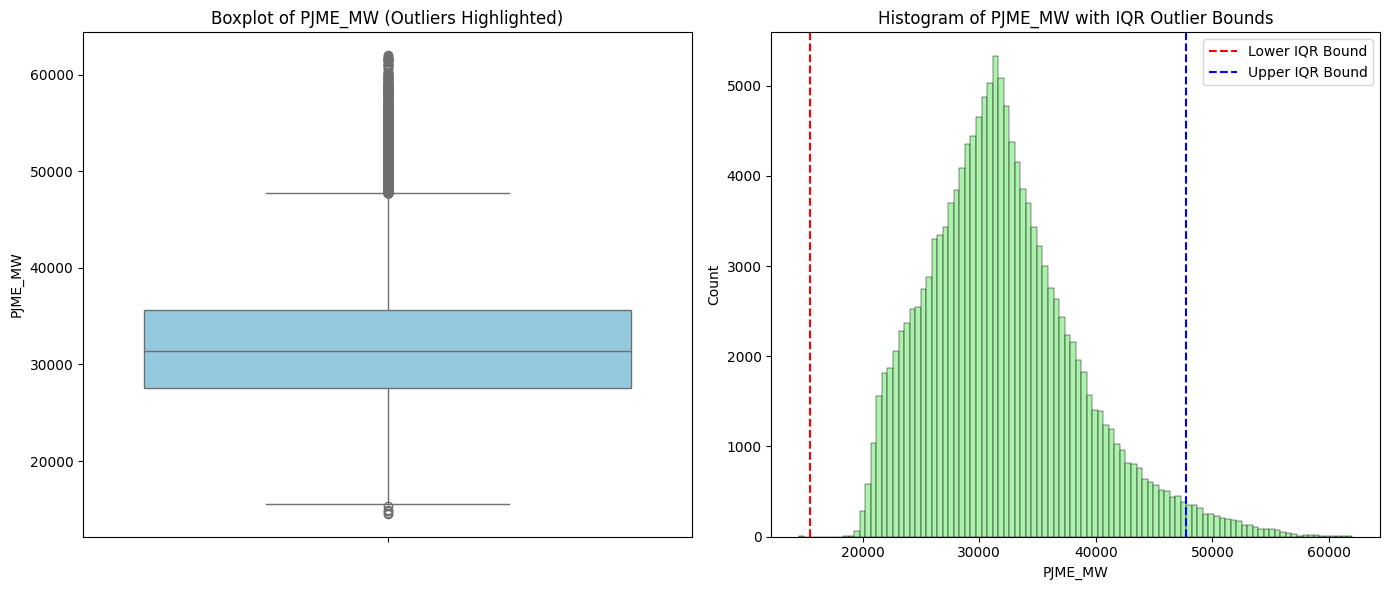

In [8]:
# Set up plots to visualize outliers
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(y=Dataset1['PJME_MW'], color='skyblue', )
plt.title("Boxplot of PJME_MW (Outliers Highlighted)")

# Histogram 
plt.subplot(1, 2, 2)
sns.histplot(Dataset1['PJME_MW'], bins=100,  color='lightgreen') 
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower IQR Bound')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper IQR Bound')
plt.title("Histogram of PJME_MW with IQR Outlier Bounds")
plt.legend()

plt.tight_layout()
plt.show()

### Data Visualization - Time Series

In [9]:
'''
Visualize energy consumption (PJ ME_MW) by hour, day, and month to identify trends and seasonal patterns.
You must create three line charts aggregating data from all years. 
For example, the hour-based chart should have 24-hour format on the x-axis and consumption on the y-axis.
You will need to extract this information from the Datetime field
'''
# Extract hour, day, and month from the 'Datetime' column
Dataset1['Hour'] = Dataset1['Datetime'].dt.hour
Dataset1['DayOfWeek'] = Dataset1['Datetime'].dt.dayofweek  # Monday=0, Sunday=6 from pandas documentation https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

Dataset1['Month'] = Dataset1['Datetime'].dt.month

# Aggregate average energy consumption by hour, day and month
hourly_avg = Dataset1.groupby('Hour')['PJME_MW'].mean()
daily_avg = Dataset1.groupby('DayOfWeek')['PJME_MW'].mean()
monthly_avg = Dataset1.groupby('Month')['PJME_MW'].mean()


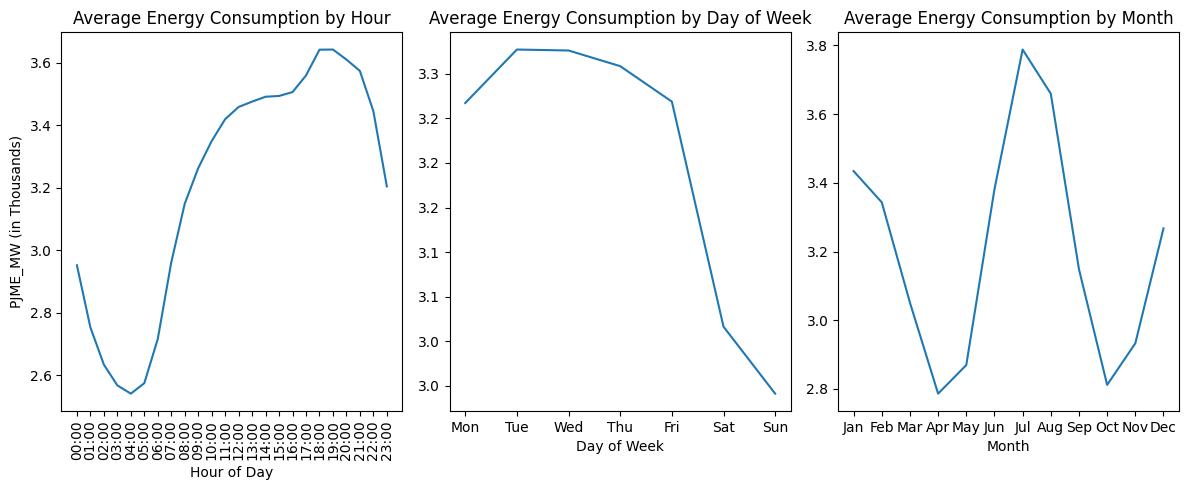

In [10]:
plt.figure(figsize=(12, 5))

# Average energy consumption by hour
plt.subplot(1, 3, 1)
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.xticks(
    ticks=range(0, 24),
    labels=[f"{i:02d}:00" for i in range(24)],
    rotation=90
)
plt.title("Average Energy Consumption by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("PJME_MW (in Thousands)")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-4:.1f}'))  # in thousands

# Average energy consumption by day
plt.subplot(1, 3, 2)
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.lineplot(x=daily_avg.index, y=daily_avg.values)
plt.xticks(ticks=range(7), labels=day_labels)
plt.title("Average Energy Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-4:.1f}'))  # in thousands

# Average energy consumption by month
plt.subplot(1, 3, 3)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.xticks(ticks=range(1, 13), labels=month_labels)
plt.title("Average Energy Consumption by Month")
plt.xlabel("Month")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-4:.1f}'))  # in thousands

plt.tight_layout()
plt.show()

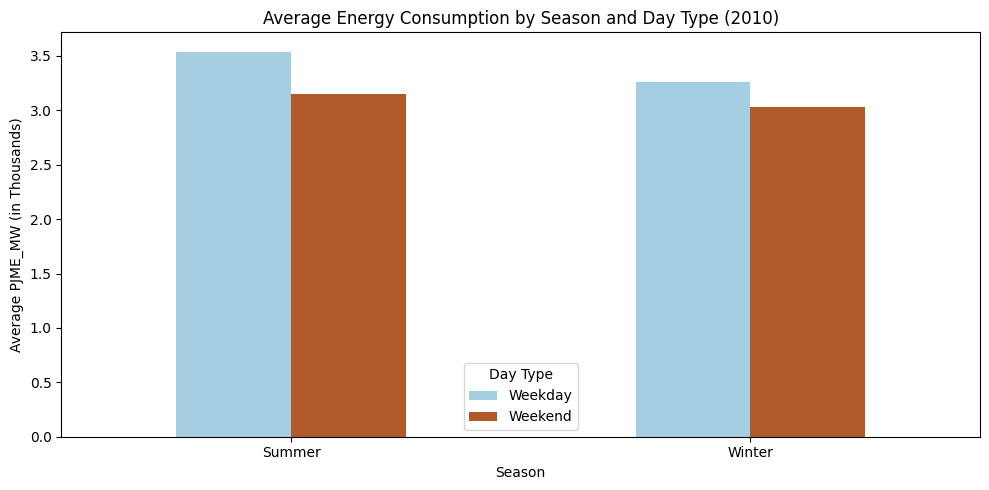

In [11]:
'''
Create time series charts to compare energy consumption across different time periods: 
Define two periods: Winter (November to April) and Summer (May to October). Choose one year from the dataset. 
Create a Python function to extract weekend days.
Generate a chart comparing Weekdays vs Weekends energy consumption. Comment on the charts.
'''
# Filter dataset for the selected year: 2010
Dataset1_2010 = Dataset1[Dataset1['Datetime'].dt.year == 2010].copy()

# Define weekend function
def is_weekend(dt):
    return dt.weekday() >= 5  # Saturday=5, Sunday=6

# Define season function
def label_season(month):
    return "Winter" if month in [11, 12, 1, 2, 3, 4] else "Summer"

# Assign season to each row
Dataset1_2010['Season'] = Dataset1_2010['Datetime'].dt.month.apply(label_season)

# Assign DayType to each row
Dataset1_2010['DayType'] = Dataset1_2010['Datetime'].apply(lambda x: "Weekend" if is_weekend(x) else "Weekday")

# Group by Season and DayType and calculate average PJME_MW
grouped = Dataset1_2010.groupby(['Season', 'DayType'])['PJME_MW'].mean().reset_index()

# Pivot for plotting
pivot_Dataset1_2010 = grouped.pivot(index='Season', columns='DayType', values='PJME_MW')

# Bar chart
pivot_Dataset1_2010.plot(kind='bar', figsize=(10, 5), colormap='Paired')
plt.title("Average Energy Consumption by Season and Day Type (2010)")
plt.ylabel("Average PJME_MW (in Thousands)")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.legend(title="Day Type", loc="lower center")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-4:.1f}'))  # in thousands

plt.tight_layout()
plt.show()

### Data Visualization - Distributions

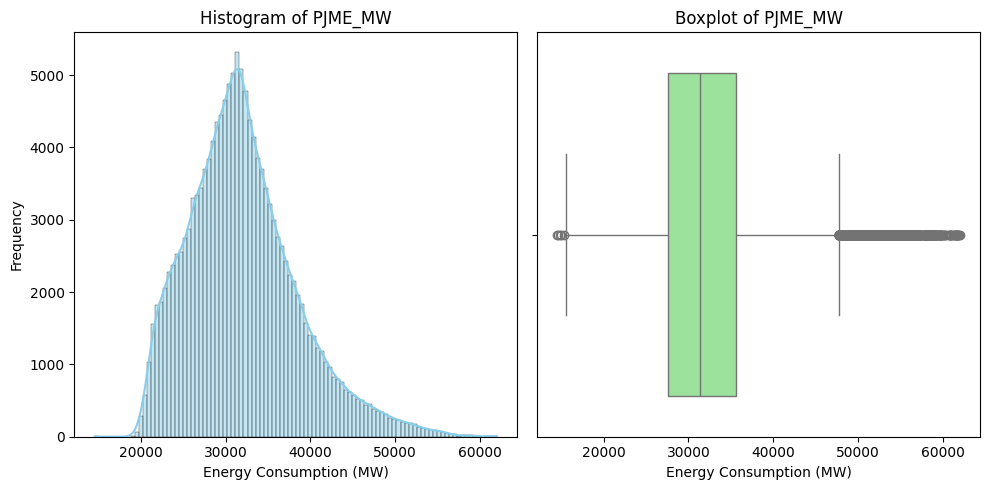

In [12]:
'''
Create histograms to visualize the distribution of energy consumption (PJME_MW) and comment what type it is.
Use boxplots to analyze the spread of energy consumption.
'''
# Set up figure for histogram and boxplot
plt.figure(figsize=(10, 5))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(Dataset1['PJME_MW'], bins=100, kde=True, color='skyblue')
plt.title("Histogram of PJME_MW")
plt.xlabel("Energy Consumption (MW)")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=Dataset1['PJME_MW'], color='lightgreen')
plt.title("Boxplot of PJME_MW")
plt.xlabel("Energy Consumption (MW)")

plt.tight_layout()
plt.show()

### Clustering

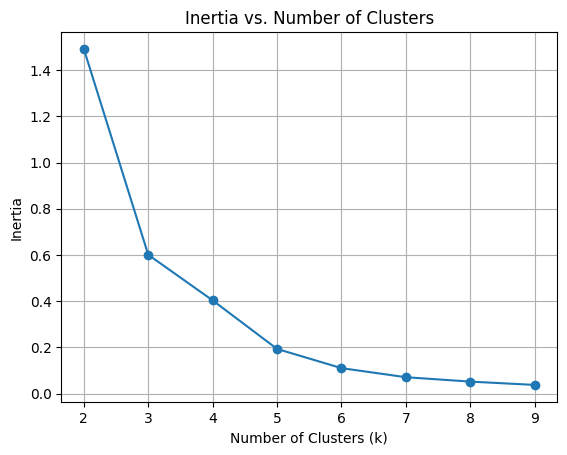

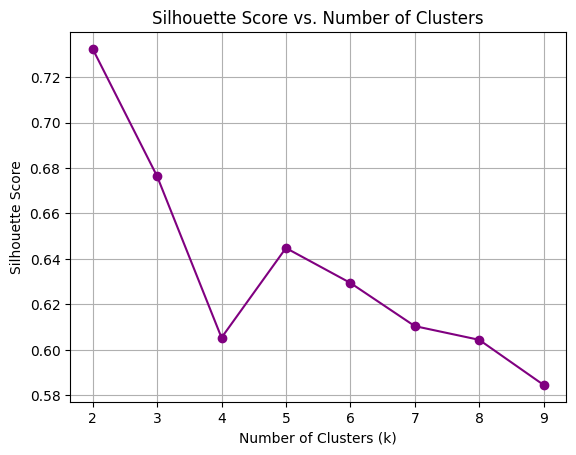

In [13]:
'''
Apply clustering algorithms (e.g., K-means) to group hours or days based on energy consumption patterns.
'''
# Aggregate mean energy consumption by hour
hourly_avgConsum = Dataset1.groupby(Dataset1['Hour'])['PJME_MW'].mean().reset_index()
hourly_avgConsum.columns = ['Hour', 'PJME_MW']
# Normalize dataset
scaler = RobustScaler()
hourly_avgConsum['PJME_MW_Scaled'] = scaler.fit_transform(hourly_avgConsum[['PJME_MW']])

# Elbow Method
inertia_values = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(hourly_avgConsum[['PJME_MW_Scaled']])
    inertia_values.append(model.inertia_)
# Plot
plt.plot(K_range, inertia_values, marker='o')
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Silhouette Score
silhouette_scores = []

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(hourly_avgConsum[['PJME_MW_Scaled']])
    labels = model.predict(hourly_avgConsum[['PJME_MW_Scaled']])
    score = silhouette_score(hourly_avgConsum[['PJME_MW_Scaled']], labels)
    silhouette_scores.append(score)
# Plot
plt.plot(range(2, 10), silhouette_scores, marker='o', color='purple')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Apply KMeans clustering
model = KMeans(n_clusters=3, random_state=42)
model.fit(hourly_avgConsum[['PJME_MW_Scaled']])

# Create the labels from the model
labels=model.predict(hourly_avgConsum[['PJME_MW_Scaled']])
# Add the labels into the Dataset
hourly_avgConsum['Cluster'] = labels

    Hour       PJME_MW  PJME_MW_Scaled  Cluster
0      0  29523.611194       -0.727289        0
1      1  27535.589964       -1.061678        2
2      2  26344.055207       -1.262096        2
3      3  25679.097666       -1.373943        2
4      4  25414.924728       -1.418377        2
5      5  25749.431000       -1.362113        2
6      6  27162.853912       -1.124373        2
7      7  29611.046880       -0.712582        0
8      8  31490.827831       -0.396400        0
9      9  32628.888247       -0.204976        0
10    10  33497.403433       -0.058891        1
11    11  34197.643117        0.058891        1
12    12  34588.618356        0.124653        1
13    13  34759.571146        0.153408        1
14    14  34916.601684        0.179821        1
15    15  34940.669693        0.183869        1
16    16  35065.392209        0.204848        1
17    17  35596.051502        0.294105        1
18    18  36421.931496        0.433020        1
19    19  36426.629911        0.433810  

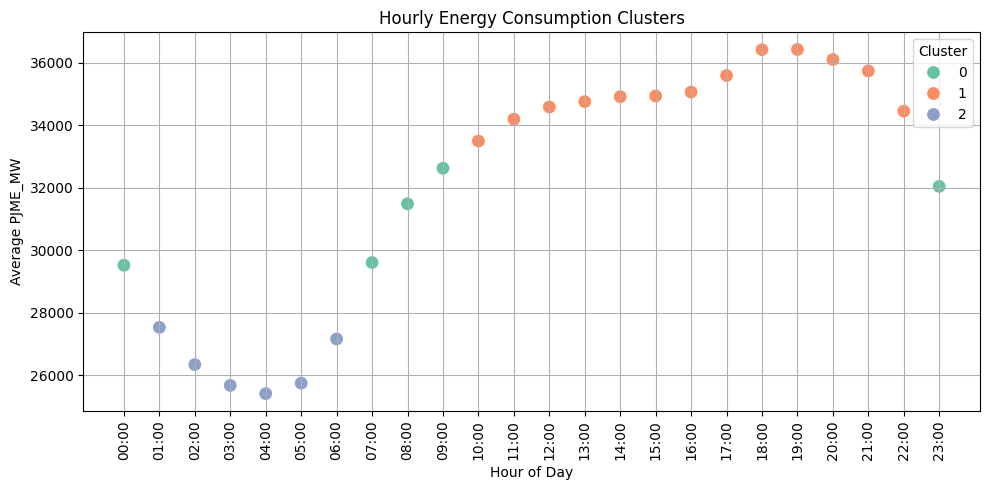

In [14]:
'''
Analyze the characteristics of different clusters to identify common patterns. For example, hours with similar consumption patterns.
'''
# Sort for plotting
hourly_avgConsum.sort_values('Hour', inplace=True)
hourly_avgConsum.reset_index(drop=True, inplace=True)

# Clustering result
print(hourly_avgConsum.head(24))  # Displays all 24 hours with cluster labels

plt.figure(figsize=(10, 5))
sns.scatterplot(data=hourly_avgConsum, x='Hour', y='PJME_MW', hue='Cluster', palette='Set2', s=100)
plt.title("Hourly Energy Consumption Clusters")
plt.xlabel("Hour of Day")
plt.ylabel("Average PJME_MW")
plt.xticks(
    ticks=range(0, 24),
    labels=[f"{i:02d}:00" for i in range(24)],
    rotation=90
)
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 2: Household Energy Consumption (Dataset: household_power_consumption)


### Libraries Load

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV, RFE

### Dataset Load

In [16]:
# Read household_power_consumption.txt
Dataset2 = pd.read_csv('Data/household_power_consumption.txt', sep=';')

print(Dataset2.info())
print("="* 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


C:\Users\User\AppData\Local\Temp\ipykernel_53804\3955100295.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  Dataset2 = pd.read_csv('Data/household_power_consumption.txt', sep=';')


In [17]:
# Convert 'Date' and 'Time' to datetime
Dataset2['Date'] = pd.to_datetime(Dataset2['Date'], format='%d/%m/%Y').dt.date
Dataset2['Time'] = pd.to_datetime(Dataset2['Time'], format='%H:%M:%S').dt.time
Dataset2['Datetime'] = pd.to_datetime(Dataset2['Date'].astype(str) + ' ' + Dataset2['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')

# Convert the rest of the columns to numeric, forcing errors to NaN
cols = ['Global_active_power','Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in cols:
    Dataset2[col] = pd.to_numeric(Dataset2[col], errors='coerce')

# Calculate percentage of missing values
missing_values = Dataset2.isna().mean() * 100  
print(missing_values.apply(lambda x: f"{x:.2f}%"))  # format as percentage 
print("="* 50)

# Drop rows with NaN values
Dataset2.dropna(inplace=True)  

print(Dataset2.info())
print("="* 50)

# Re-calculate percentage of missing values
missing_values = Dataset2.isna().mean() * 100 
print(missing_values.apply(lambda x: f"{x:.2f}%"))  #format output as percentage
print("="* 50)

Date                     0.00%
Time                     0.00%
Global_active_power      1.25%
Global_reactive_power    1.25%
Voltage                  1.25%
Global_intensity         1.25%
Sub_metering_1           1.25%
Sub_metering_2           1.25%
Sub_metering_3           1.25%
Datetime                 0.00%
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
mem

### Statistical Analysis - Time Series Analysis

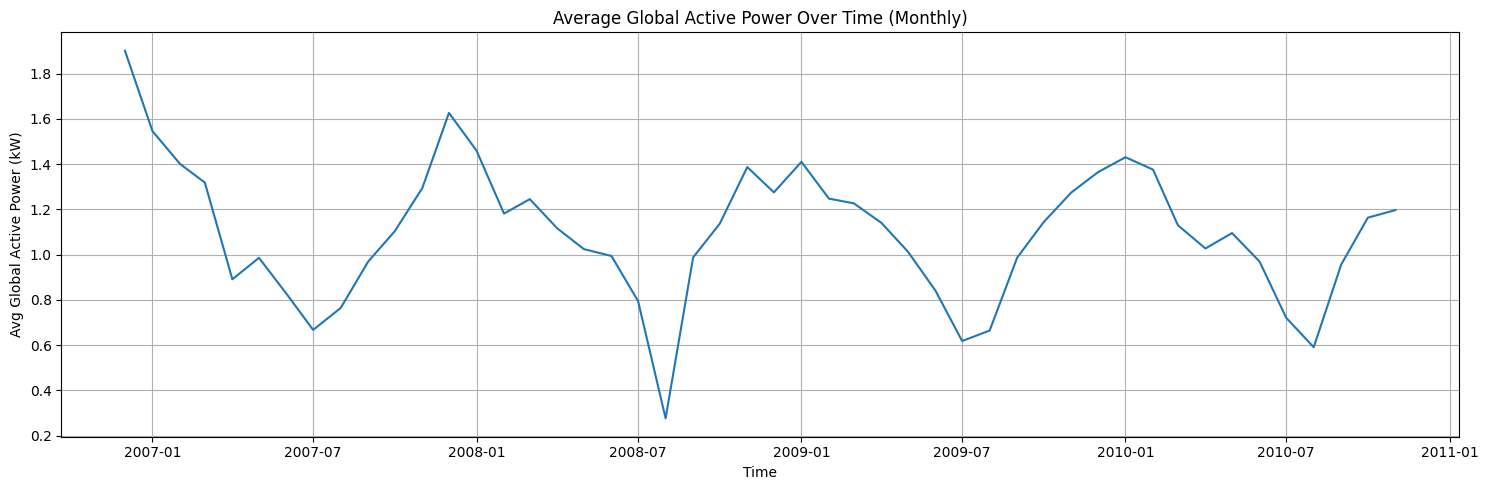

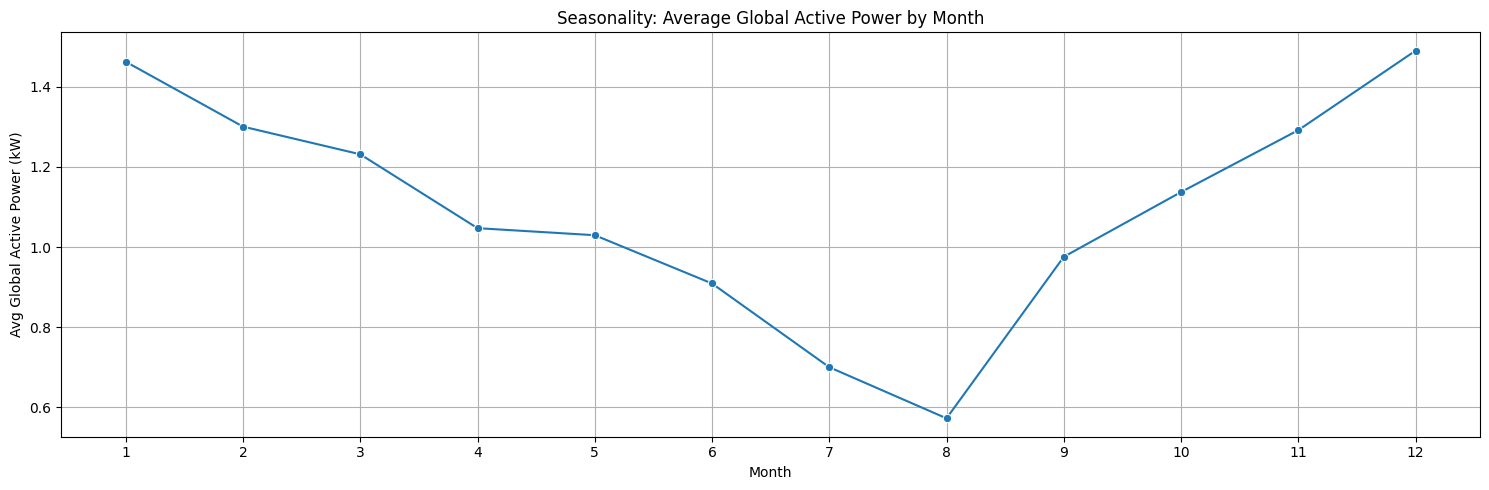

In [18]:
'''
Identify seasonality and trends in energy consumption (Global_active_power) by month and year.
'''
# Extract year and month
Dataset2['Year'] = Dataset2['Datetime'].dt.year
Dataset2['Month'] = Dataset2['Datetime'].dt.month

# Group by Year and Month to calculate average Global_active_power
monthly_avg = Dataset2.groupby(['Year', 'Month'])['Global_active_power'].mean().reset_index()

# Create a formatted string for plotting
monthly_avg['YearMonth'] = pd.to_datetime(monthly_avg[['Year', 'Month']].assign(DAY=1))

# Line plot of trend over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=monthly_avg, x='YearMonth', y='Global_active_power')
plt.title("Average Global Active Power Over Time (Monthly)")
plt.xlabel("Time")
plt.ylabel("Avg Global Active Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Average by month (across all years) to see seasonality
monthly_seasonality = Dataset2.groupby('Month')['Global_active_power'].mean().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=monthly_seasonality, x='Month', y='Global_active_power', marker='o')
plt.title("Seasonality: Average Global Active Power by Month")
plt.xlabel("Month")
plt.ylabel("Avg Global Active Power (kW)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

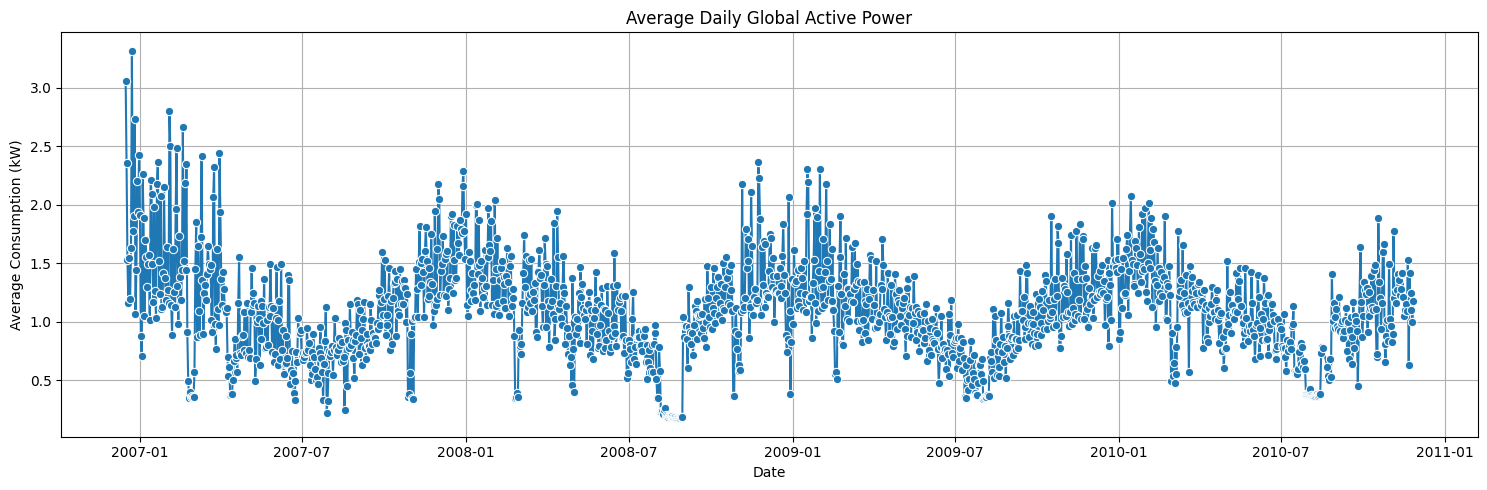

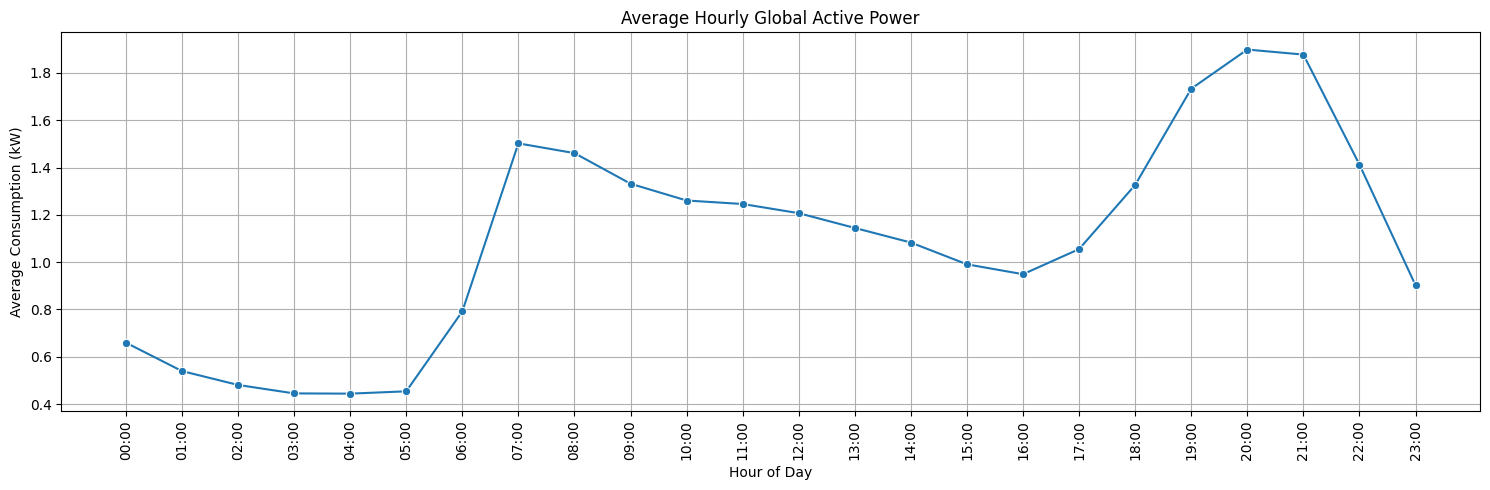

In [19]:
'''
Calculate the average daily and hourly energy consumption
'''
# Average daily energy consumption
daily_avg = Dataset2.groupby(['Date'])['Global_active_power'].mean().reset_index()

# Plot of average daily energy over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=daily_avg, x='Date',y='Global_active_power', marker='o')
plt.title("Average Daily Global Active Power")
plt.xlabel("Date")
plt.ylabel("Average Consumption (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Average hourly energy consumption
Dataset2['Hour'] = Dataset2['Datetime'].dt.hour
hourly_avg = Dataset2.groupby(Dataset2['Hour'])['Global_active_power'].mean().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=hourly_avg, x='Hour', y='Global_active_power', marker='o')
plt.title("Average Hourly Global Active Power")
plt.xlabel("Hour of Day")
plt.ylabel("Average Consumption (kW)")
plt.xticks(
    ticks=range(0, 24),
    labels=[f"{i:02d}:00" for i in range(24)],
    rotation=90
)
plt.grid(True)
plt.tight_layout()
plt.show()


### Statistical Analysis - Variable Correlations

Pearson correlation (Voltage vs Global_active_power): -0.3998


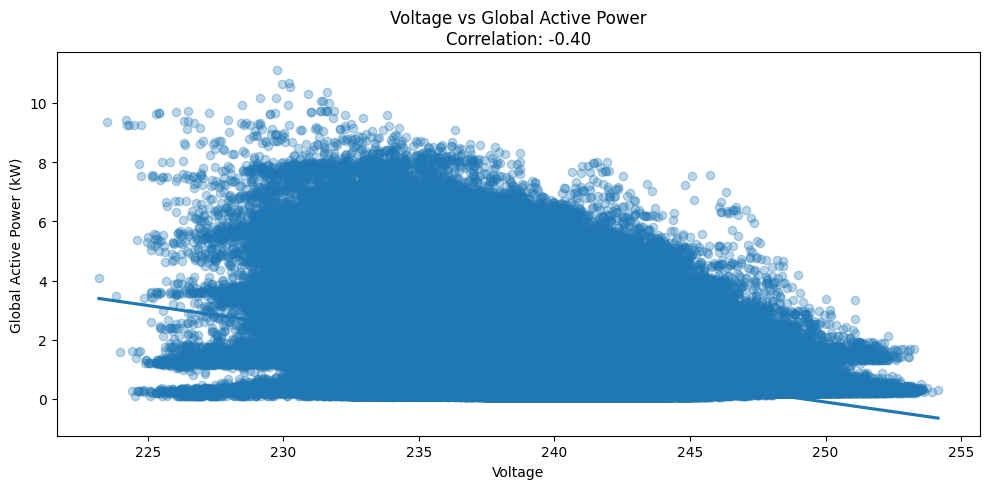

In [20]:
'''
Examine the correlation between Voltage and Global_active_power
'''
# Correlation: Voltage vs Global_active_power 
corr_volt_gap = Dataset2[['Voltage', 'Global_active_power']].corr().iloc[0, 1]
print(f"Pearson correlation (Voltage vs Global_active_power): {corr_volt_gap:.4f}")

plt.figure(figsize=(10, 5))
sns.regplot(data=Dataset2, x='Voltage', y='Global_active_power', scatter_kws={'alpha':0.3})
plt.title(f"Voltage vs Global Active Power\nCorrelation: {corr_volt_gap:.2f}")
plt.xlabel("Voltage")
plt.ylabel("Global Active Power (kW)")
plt.tight_layout()
plt.show()

In [21]:
'''
Analyze how energy consumption relates to sub-meter readings (Sub_metering_1/2/3). 
'''
# Correlation: Global_active_power vs Sub_meterings 
submeter_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
corr_matrix = Dataset2[['Global_active_power'] + submeter_cols].corr()

print("\nCorrelations with Global_active_power:")
print(corr_matrix['Global_active_power'].drop('Global_active_power'))



Correlations with Global_active_power:
Sub_metering_1    0.484401
Sub_metering_2    0.434569
Sub_metering_3    0.638555
Name: Global_active_power, dtype: float64


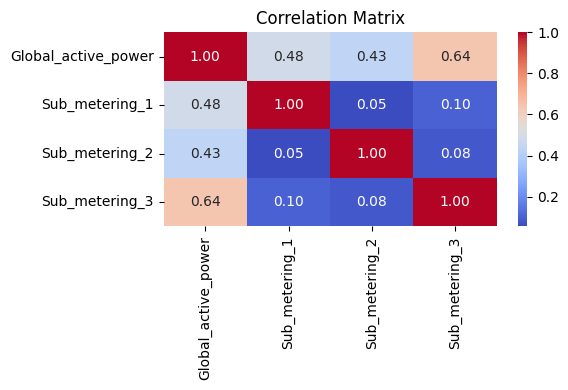

In [22]:
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

<Figure size 100x100 with 0 Axes>

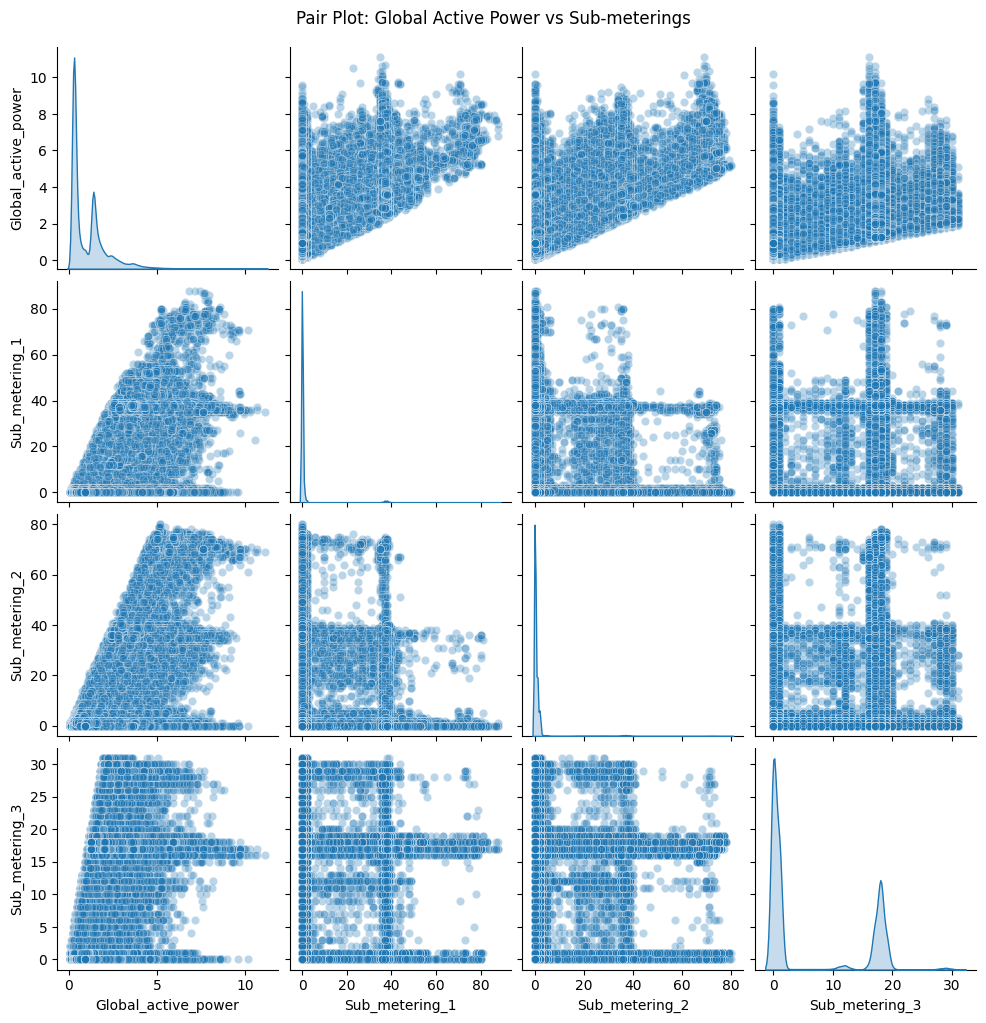

In [23]:
# Pair plot 
plt.figure(figsize=(1,1))
sns.pairplot(Dataset2[['Global_active_power'] + submeter_cols], diag_kind='kde', plot_kws={'alpha':0.3})
plt.suptitle("Pair Plot: Global Active Power vs Sub-meterings", y=1.02)
plt.show()

### Multiple Linear Regression - Model Creation

In [24]:
'''Build a multiple linear regression model to predict Global_active_power using relevant features'''
Dataset3 = pd.read_csv('Data/household_power_consumption.txt', sep=';')

# Define features and target
features = [
    'Voltage', 'Global_intensity', 'Global_reactive_power',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
target = 'Global_active_power'

# Drop rows with missing values
Dataset3_model = Dataset3[features + [target]] = Dataset3[features + [target]].apply(pd.to_numeric, errors='coerce')
Dataset3_model = Dataset3[features + [target]].dropna()

# Split into train/test
X = Dataset3_model[features]
y = Dataset3_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
# Shapiro-Wilk test (using a 5000-row sample)
for col in features:
    sample_Dataset3_model = Dataset3_model[col].sample(5000, random_state=42)
    stat, p = shapiro(sample_Dataset3_model)
    normality = "Normal" if p > 0.05 else "Not normal"
    print(f"{col}: p-value={p:.4f} → {normality}")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Linear Regression
full_model = LinearRegression()
full_model.fit(X_train_scaled, y_train)

# Output coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': full_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print(50 * "=")
print("Intercept:", full_model.intercept_)
print("\nCoefficients:\n", coefficients)

C:\Users\User\AppData\Local\Temp\ipykernel_53804\1411082154.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  Dataset3 = pd.read_csv('Data/household_power_consumption.txt', sep=';')


Voltage: p-value=0.0000 → Not normal
Global_intensity: p-value=0.0000 → Not normal
Global_reactive_power: p-value=0.0000 → Not normal
Sub_metering_1: p-value=0.0000 → Not normal
Sub_metering_2: p-value=0.0000 → Not normal
Sub_metering_3: p-value=0.0000 → Not normal
Intercept: 0.6029134444277069

Coefficients:
                  Feature  Coefficient
1       Global_intensity     1.190189
5         Sub_metering_3     0.036990
0                Voltage     0.017367
3         Sub_metering_1    -0.000329
4         Sub_metering_2    -0.000442
2  Global_reactive_power    -0.025665


### Multiple Linear Regression - Model Evaluation

In [25]:
'''
Evaluate the model using R², RMSE, and MAE metrics
'''
# Predictions
y_train_pred = full_model.predict(X_train_scaled)
y_test_pred = full_model.predict(X_test_scaled)


# Training metrics
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

# Output
print("=== Training Performance ===")
print(f"R²:   {r2_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE:  {mae_train:.4f}")

# Due to near perfect metrics of the model we are computing the metrics on the test set to ensure model generalization
# Testing metrics
r2_full_model = r2_score(y_test, y_test_pred)
rmse_full_model = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_full_model = mean_absolute_error(y_test, y_test_pred)

# Output
print("\n=== Testing Performance ===")
print(f"R²:   {r2_full_model:.4f}")
print(f"RMSE: {rmse_full_model:.4f}")
print(f"MAE:  {mae_full_model:.4f}")


=== Training Performance ===
R²:   0.9985
RMSE: 0.0407
MAE:  0.0259

=== Testing Performance ===
R²:   0.9986
RMSE: 0.0404
MAE:  0.0258


Optimal number of features: 6
Selected features: ['Voltage', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


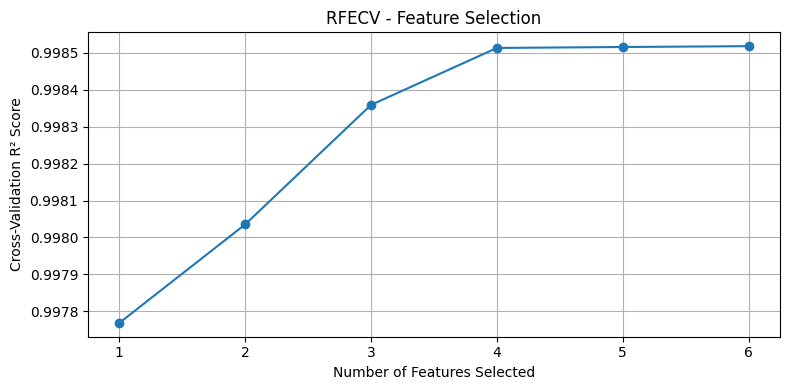

In [26]:
'''
Examine feature importance: Could any feature be omitted? Run the model with fewer features and comment on the outcome
'''
# Full model with RFECV
X_rfecv = Dataset3_model[features]
y_rfecv = Dataset3_model[target]

# Train/test split 
X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = train_test_split(X_rfecv, y_rfecv, test_size=0.2, random_state=42)

# Scale features
X_train_scaled_rfecv = scaler.fit_transform(X_train_rfecv)
X_test_scaled_rfecv = scaler.transform(X_test_rfecv)

# Initialize model
rfecv_model = LinearRegression()

# RFECV for r2
rfecv = RFECV(estimator=rfecv_model, step=1, cv=5, scoring='r2')
rfecv.fit(X_train_scaled_rfecv, y_train_rfecv)

# Best features
selected_features = [f for f, keep in zip(features, rfecv.support_) if keep]
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", selected_features)

# Plot number of features vs CV score
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(features) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation R² Score")
plt.title("RFECV - Feature Selection")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Initialize RFE with 4 features
rfe_4 = RFE(estimator=LinearRegression(), n_features_to_select=4) # by default, RFE selects the best features based on the estimator's R²
rfe_4.fit(X_train_scaled, y_train)

# Extract selected features
selected_4_features = [f for f, keep in zip(features, rfe_4.support_) if keep]
print("Top 4 features for highest R² before plateau:", selected_4_features)


Top 4 features for highest R² before plateau: ['Voltage', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_3']


In [28]:
# Reduced model
reduced_features = [
    'Voltage', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_3'
]
X_red = Dataset3_model[reduced_features]
y_red = Dataset3_model[target]

# Train/test split 
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Scale features
X_red_train_scaled = scaler.fit_transform(X_red_train)
X_red_test_scaled = scaler.transform(X_red_test)

# Fit Linear Regression
reduced_model = LinearRegression()
reduced_model.fit(X_red_train_scaled, y_red_train)

# Output coefficients
coefficients = pd.DataFrame({
    'Feature': reduced_features,
    'Coefficient': reduced_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print(50 * "=")
print("Intercept:", reduced_model.intercept_)
print("\nCoefficients:\n", coefficients)

# Predictions
y_red_train_pred = reduced_model.predict(X_red_train_scaled)
y_red_test_pred = reduced_model.predict(X_red_test_scaled)

# Training metrics
r2_red_train = r2_score(y_red_train, y_red_train_pred)
rmse_red_train = np.sqrt(mean_squared_error(y_red_train, y_red_train_pred))
mae_red_train = mean_absolute_error(y_red_train, y_red_train_pred)
# Output
print("=== Training Performance ===")
print(f"R²:   {r2_red_train:.4f}")
print(f"RMSE: {rmse_red_train:.4f}")
print(f"MAE:  {mae_red_train:.4f}")

# Testing metrics
r2_reduced_model = r2_score(y_red_test, y_red_test_pred)
rmse_reduced_model = np.sqrt(mean_squared_error(y_red_test, y_red_test_pred))
mae_reduced_model = mean_absolute_error(y_red_test, y_red_test_pred)
# Output
print("\n=== Testing Performance ===")
print(f"R²:   {r2_reduced_model:.4f}")
print(f"RMSE: {rmse_reduced_model:.4f}")
print(f"MAE:  {mae_reduced_model:.4f}")

Intercept: 0.6023912863124885

Coefficients:
                  Feature  Coefficient
1       Global_intensity     1.186702
3         Sub_metering_3     0.040032
0                Voltage     0.017326
2  Global_reactive_power    -0.025564
=== Training Performance ===
R²:   0.9985
RMSE: 0.0407
MAE:  0.0261

=== Testing Performance ===
R²:   0.9985
RMSE: 0.0404
MAE:  0.0260


### Clustering - Data Pre-Processing

In [29]:
'''
Normalize the variables to comparable scales.
'''
Dataset4 = pd.read_csv('Data/household_power_consumption.txt', sep=';')

# Columns conversion to appropriate types 
Dataset4['Date'] = pd.to_datetime(Dataset4['Date'], format='%d/%m/%Y').dt.date
Dataset4['Time'] = pd.to_datetime(Dataset4['Time'], format='%H:%M:%S').dt.time
Dataset4['Datetime'] = pd.to_datetime(Dataset4['Date'].astype(str) + ' ' + Dataset4['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')
cols = ['Global_active_power','Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in cols:
    Dataset4[col] = pd.to_numeric(Dataset4[col], errors='coerce')
# Drop NaNs
df_cluster = Dataset4[cols].dropna()

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform
X_scaled = scaler.fit_transform(df_cluster)

# Convert back to DataFrame for easy viewing
Dataset4_scaled = pd.DataFrame(X_scaled, columns=cols, index=df_cluster.index)

print(Dataset4_scaled.head())

C:\Users\User\AppData\Local\Temp\ipykernel_53804\3444855549.py:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  Dataset4 = pd.read_csv('Data/household_power_consumption.txt', sep=';')


   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
0             2.962295               2.178082 -1.582051              3.16   
1             3.900000               2.301370 -1.892308              4.08   
2             3.911475               2.726027 -1.979487              4.08   
3             3.922951               2.753425 -1.864103              4.08   
4             2.511475               2.931507 -1.366667              2.64   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             0.0             1.0        0.941176  
1             0.0             1.0        0.882353  
2             0.0             2.0        0.941176  
3             0.0             1.0        0.941176  
4             0.0             1.0        0.941176  


### Clustering - Clustering

In [30]:
'''' 
Apply K-means to group time periods based on consumption patterns
'''
X_scaled_sample = Dataset4_scaled.sample(n=204928, random_state=42) # 10% of observations due to very large dataset

k_values = range(2, 6)
inertias = []
silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42) #, n_init=10
    labels = kmeans.fit_predict(X_scaled_sample)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled_sample, labels))

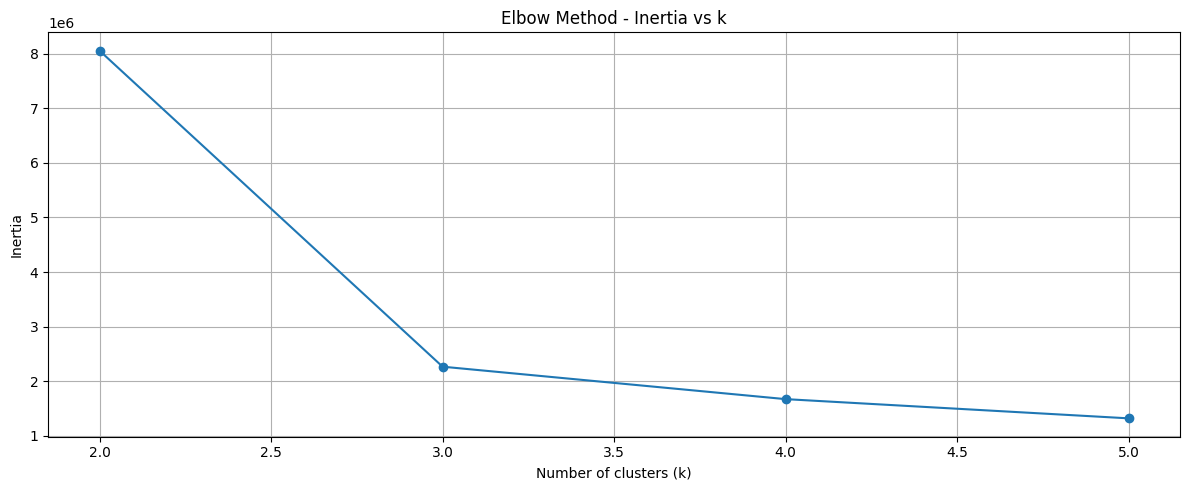

In [31]:
# Inertia 
plt.figure(figsize=(12, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method - Inertia vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

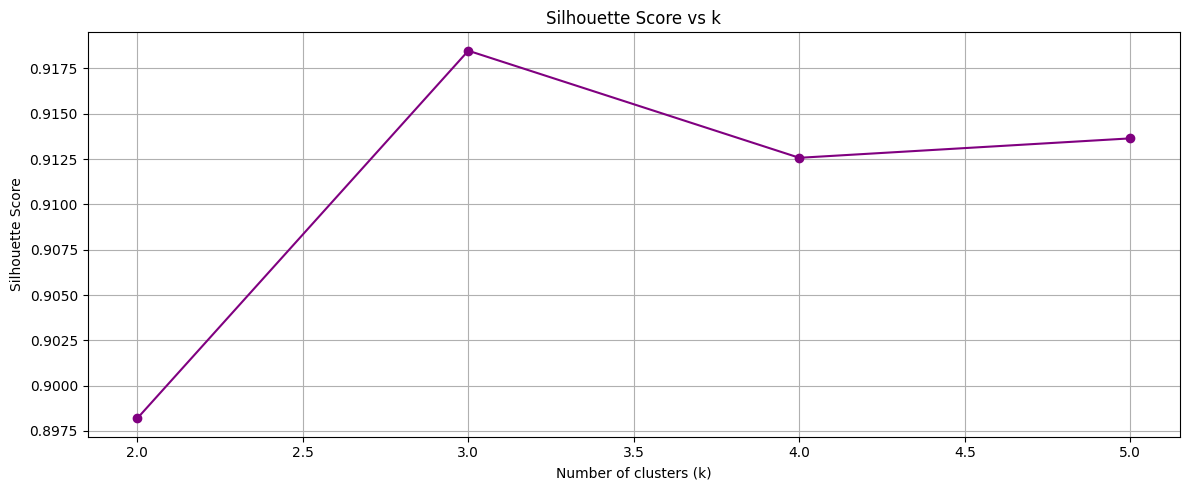

In [32]:
# Silhouette score
plt.figure(figsize=(12, 5))
plt.plot(k_values, silhouettes, marker='o', color='purple')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Fit final model
k_final = 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels_full = kmeans_final.fit_predict(X_scaled)

### Clustering - Visualization

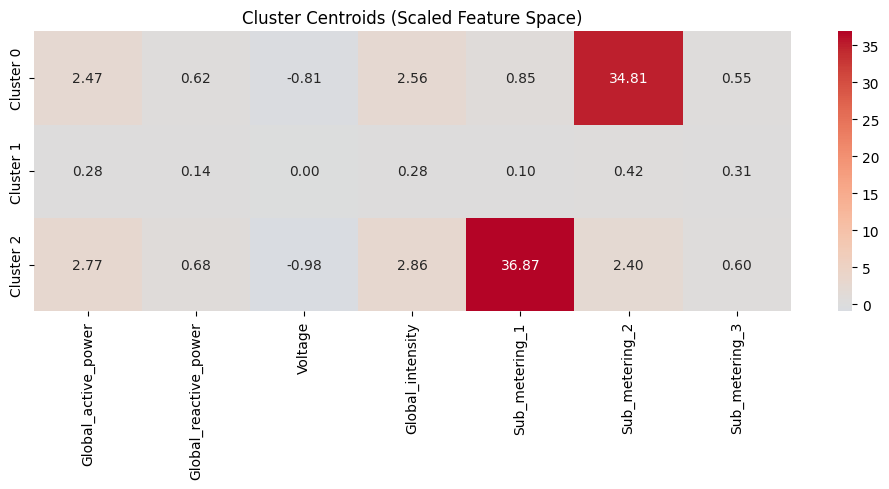


Cluster sizes:
Cluster
0      49259
1    1944286
2      55735
Name: count, dtype: int64


In [34]:
'''
Analyze cluster characteristics to identify common consumption patterns.
'''
# Attach cluster labels
df_clustered = df_cluster.copy()
df_clustered['Cluster'] = labels_full

# Centroids 
centroids_scaled = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=cols,
    index=[f"Cluster {i}" for i in range(k_final)]
)

'''
Use scatter plots and cluster heatmaps to visualize clustering results.
'''
# Heatmap of cluster centroids
plt.figure(figsize=(10, 5))
sns.heatmap(centroids_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Cluster Centroids (Scaled Feature Space)")
plt.tight_layout()
plt.show()

# Size of each cluster
print("\nCluster sizes:")
print(df_clustered['Cluster'].value_counts().sort_index())

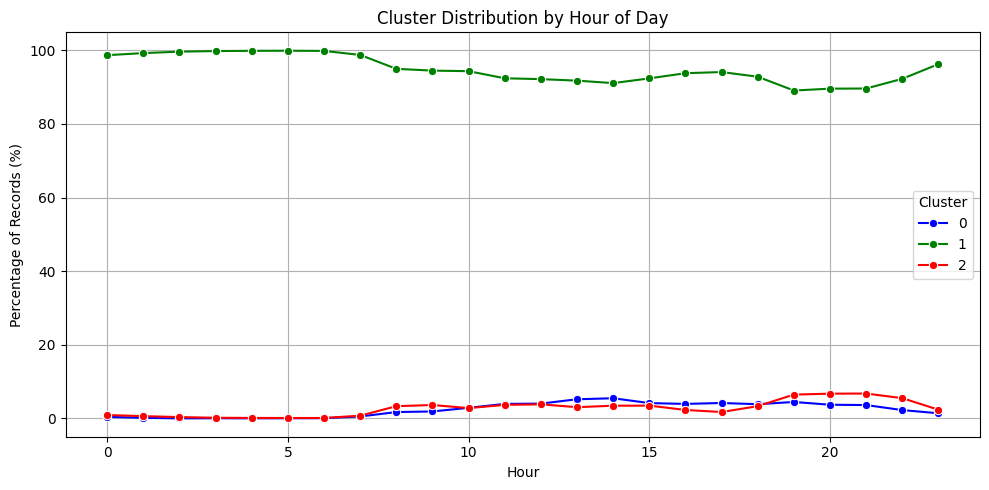

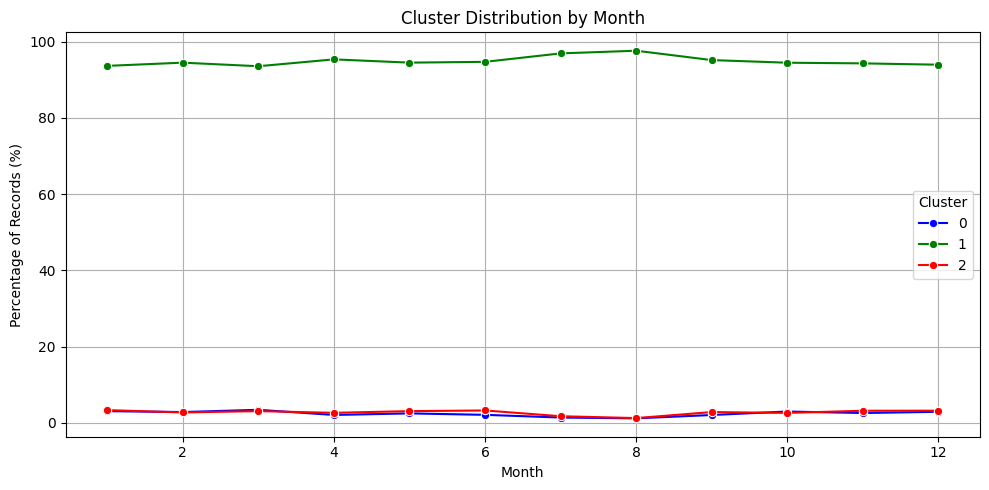

In [35]:
''' 
Visualization: Create charts comparing energy consumption patterns across different clusters. 
''' 
# Copy of the dataset with Datetime
df_time_clusters = Dataset4.copy()
df_time_clusters = df_time_clusters.loc[df_cluster.index]  # align to clustered rows
df_time_clusters['Cluster'] = labels_full

# Extract hour, day, and month from Datetime
df_time_clusters['Hour'] = df_time_clusters['Datetime'].dt.hour
df_time_clusters['Month'] = df_time_clusters['Datetime'].dt.month

# Distribution by Hour
hourly_counts = df_time_clusters.groupby(['Hour', 'Cluster']).size().reset_index(name='Count')
hourly_totals = hourly_counts.groupby('Hour')['Count'].transform('sum')
hourly_counts['Percent'] = hourly_counts['Count'] / hourly_totals * 100

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_counts, x='Hour', y='Percent', hue='Cluster', marker='o'
              ,palette={0: 'blue', 1: 'green', 2: 'red'})
plt.title("Cluster Distribution by Hour of Day")
plt.ylabel("Percentage of Records (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution by Month
monthly_counts = df_time_clusters.groupby(['Month', 'Cluster']).size().reset_index(name='Count')
monthly_totals = monthly_counts.groupby('Month')['Count'].transform('sum')
monthly_counts['Percent'] = monthly_counts['Count'] / monthly_totals * 100

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_counts, x='Month', y='Percent', hue='Cluster', marker='o'
             ,palette={0: 'blue', 1: 'green', 2: 'red'})
plt.title("Cluster Distribution by Month")
plt.ylabel("Percentage of Records (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
